In [5]:
import yfinance as yf
from datetime import datetime, timedelta
import pytz

stock = yf.Ticker('BEL.NS')

ist = pytz.timezone('Asia/Kolkata')
start_date = datetime.strptime(datetime.now(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d'), '%Y-%m-%d').replace(tzinfo=ist)
end_date = (start_date + timedelta(days=1))

# Get 5-minute interval data
df = stock.history(
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval='5m'
)


#df = stock.history(period = '1d', interval = '5m')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-07-01 12:10:00+05:30,431.950012,432.250000,431.799988,431.850006,148965,0.0,0.0
2025-07-01 12:15:00+05:30,432.000000,432.500000,431.850006,432.350006,143726,0.0,0.0
2025-07-01 12:20:00+05:30,432.450012,432.799988,432.350006,432.600006,177630,0.0,0.0
2025-07-01 12:25:00+05:30,432.600006,432.700012,432.200012,432.200012,103680,0.0,0.0
2025-07-01 12:30:00+05:30,432.149994,432.149994,432.149994,432.149994,0,0.0,0.0


In [ ]:
first_hour = df.between_time('09:15', '10:15')
start_price = first_hour.iloc[0]['Close']
end_price = first_hour.iloc[-1]['Close']
print(f"Start Price: {start_price}, End Price: {end_price}")
percent_change = ((end_price - start_price) / start_price) * 100
print(percent_change)

1.9341226670024518


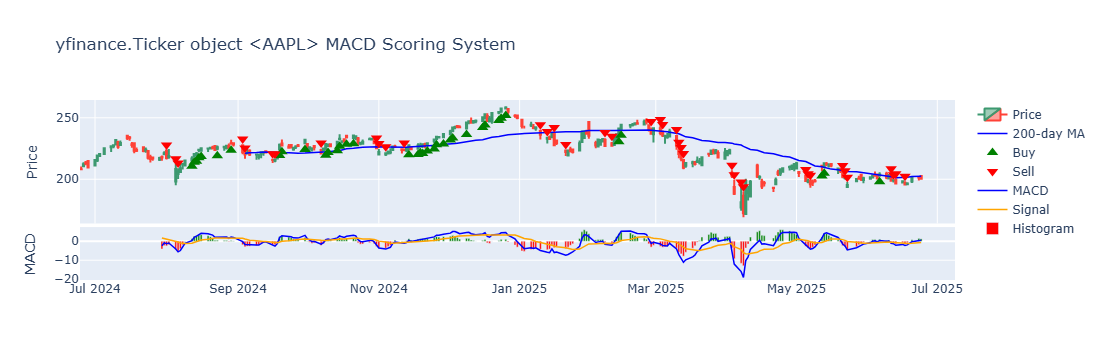

In [30]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

stock = yf.Ticker('AAPL')
df = stock.history(period = '1y')

# Calculate MACD and 200-day MA
df.ta.macd(close='Close', fast=3, slow=10, signal=16, append=True)
df.rename(columns={
    'MACD_3_10_16': 'MACD',
    'MACDs_3_10_16': 'Signal',
    'MACDh_3_10_16': 'Histogram'
}, inplace=True)
df['MA_200'] = df['Close'].rolling(window=50).mean()

# Precompute shifted values for comparison
df['Histogram_prev'] = df['Histogram'].shift(1)
df['MACD_prev'] = df['MACD'].shift(1)
    
# Define Scoring Function (fixed)
def macd_score(row):
    score = 0
    # Bullish Conditions
    if row['MACD'] > row['Signal']:
        score += 2
    if row['MACD'] > 0:
        score += 1
    if row['Histogram'] > row['Histogram_prev']:  # Fixed: Compare with precomputed lagged value
        score += 1
    if row['MACD'] > row['MACD_prev']:  # Fixed: Compare with precomputed lagged value
        score += 1
    if row['Close'] > row['MA_200']:
        score += 1
    
    # Bearish Conditions
    if row['MACD'] < row['Signal']:
        score -= 2
    if row['MACD'] < 0:
        score -= 1
    if row['Histogram'] < row['Histogram_prev']:
        score -= 1
    if row['MACD'] < row['MACD_prev']:
        score -= 1
    if row['Close'] < row['MA_200']:
        score -= 1
    
    return score

df['MACD_Score'] = df.apply(macd_score, axis=1)

# Generate Signals
df['Trade_Signal'] = 0  # 0 = Hold, 1 = Buy, -1 = Sell
df.loc[df['MACD_Score'] >= 5, 'Trade_Signal'] = 1  # Buy
df.loc[df['MACD_Score'] <= -5, 'Trade_Signal'] = -1  # Sell

# Plotting
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights=[0.7, 0.3])

# Price and Signals
fig.add_trace(go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Price'), row=1, col=1)
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['MA_200'], 
    line=dict(color='blue', width=1.5), 
    name='200-day MA'),  # <-- Missing comma was here
    row=1, 
    col=1 )

# Buy/Sell Markers
buy_signals = df[df['Trade_Signal'] == 1]
sell_signals = df[df['Trade_Signal'] == -1]
fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['Low'] * 0.98, mode='markers', marker=dict(symbol='triangle-up', size=10, color='green'), name='Buy'), row=1, col=1)
fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['High'] * 1.02, mode='markers', marker=dict(symbol='triangle-down', size=10, color='red'), name='Sell'), row=1, col=1)

# MACD Subplot
fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], line=dict(color='blue', width=1.5), name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Signal'], line=dict(color='orange', width=1.5), name='Signal'), row=2, col=1)
colors = ['green' if val >= 0 else 'red' for val in df['Histogram']]
fig.add_trace(go.Bar(x=df.index, y=df['Histogram'], marker_color=colors, name='Histogram'), row=2, col=1)

# Layout
fig.update_layout(title=f"{stock} MACD Scoring System", xaxis_rangeslider_visible=False)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="MACD", row=2, col=1)
fig.show()